#Theory note
### Single-scattering modelling (Born approximation):
$$
\mathcal{L}(\rho,c)\mathbf{u}=\mathbf{s},
$$

$$
\mathcal{L}(c_m,\rho_0)\delta\mathbf{u}=\delta \mathbf{s}_0,
$$

$$
\mathbf{u}=\begin{pmatrix} p \\ v_x \\ v_z
\end{pmatrix}
$$

$$
\delta \mathbf{s}_0=\mathcal{R}\mathbf{u}=\begin{pmatrix} r & 0 & 0\\ 0 &0 &0 \\ 0 &0 &0
\end{pmatrix}\begin{pmatrix} p\\ v_x\\ v_z
\end{pmatrix}
$$

### Multi-scattering modelling:

\begin{equation}
\delta s= r^+p^++r^-p^-,
\end{equation}


\begin{equation}
p^{\pm}=\frac{1}{2}(p \pm \frac{\rho c^2}{cos \theta}v_z).
\end{equation}


\begin{equation}
\delta s=r^+\frac{\rho c^2}{cos \theta}v_z
\end{equation}

$$\mathcal{L}_{1}(c,\rho,r)=\begin{pmatrix}\partial_t & -\rho c^2 \partial_x & -(\rho c^2 \partial_z +r\frac{\rho c^2}{cos \theta}) \\
\frac{1}{\rho}\partial_x & \partial_t & 0 \\
\frac{1}{\rho}\partial_z & 0 & \partial_t \\
\end{pmatrix}.
$$

#Content

In this notebook we will demosntrate how to model multiples from the reflectity using finite difference modelling (two-way wave equation). Such modelling can be used for full wavefield LS-RTM or R-FWI

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import interactive
interactive(True)

In [6]:
%%capture
#comment '%%capture' to see the current cell's output (devito installation)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

#WARNING: following command will install devito in local environment (if running locally)
!pip install devito

from devito import *
from devito import NODE, Eq, Operator, Function, Constant, TimeFunction, VectorTimeFunction, Inc, solve, div, grad
from examples.seismic import AcquisitionGeometry
from examples.seismic import Receiver, Shot
from examples.seismic import Model, ModelElastic, plot_velocity, plot_shotrecord
from IPython.display import clear_output

In [7]:
def fdmod_operator(model,geometry, mode, dm=None, space_order=4, save=False, **kwargs):
    m, damp = model.m, 1- model.damp

    src = Receiver(name='src', grid=model.grid, time_range=geometry.time_axis, npoint=geometry.nsrc)
    rec = Receiver(name='rec', grid=model.grid, time_range=geometry.time_axis, npoint=geometry.nrec)

    deltas = TimeFunction(name='deltas', staggered=NODE, grid=model.grid, space_order=space_order, time_order=2)
    p = TimeFunction(name='p', staggered=NODE, grid=model.grid,  space_order=space_order, time_order=2)
    dp = TimeFunction(name='dp', staggered=NODE, grid=model.grid, space_order=space_order, time_order=2)
    v = VectorTimeFunction(name='v', grid=model.grid, space_order=space_order, time_order=2)
    dv = VectorTimeFunction(name='dv', grid=model.grid, space_order=space_order,time_order=2)
    
    vsave = TimeFunction(name='vsave', grid=model.grid, save=geometry.nt, space_order=space_order, time_order=2)
    Vsave = TimeFunction(name='Vsave', grid=model.grid, save=geometry.nt, space_order=space_order, time_order=2)
    
    dm = dm or Function(name="dm", grid=model.grid, space_order=0)
           

    s = model.grid.stepping_dim.spacing
    
    source = src.inject(field=p.forward, expr=src* s/ m)
    shift=0.5*dm.grid.dimensions[-1].spacing
    if mode=='fwrtm':
        #this is the modified secondary source:
        deltas = -dm * v[-1].shift(dm.grid.dimensions[-1],-0.5*dm.grid.dimensions[-1].spacing) / 2
        
        u_v = Eq(v.forward, model.damp * v + 1/model.b*model.damp * s * grad(p))
        u_p = Eq(p.forward, model.damp * p + model.b*model.damp * s * (model.vp*model.vp) * div(v.forward) + model.damp*s*deltas*model.vp*model.vp )
        u_v
        u_p
        receivers = rec.interpolate(expr=p)
        u_vsave = Eq(vsave, p)
        return Operator([u_v, u_p, receivers, source,u_vsave], subs=model.spacing_map, name='FWRTMOperator')
    if mode=='born':
        #Born modelling term:
        deltas = dm * p
        u_v = Eq(v.forward, model.damp * v + 1/model.b*model.damp * s * grad(p))
        u_p = Eq(p.forward, model.damp * p + model.b*model.damp * s * model.vp*model.vp * div(v.forward))

        u_dv = Eq(dv.forward, model.damp * dv + 1/model.b*model.damp * s * grad(dp))
        u_dp = Eq(dp.forward, model.damp * dp + model.b*model.damp * s * model.vp*model.vp * div(dv.forward) + model.damp*s*deltas*model.vp )
        u_dp
        u_dv
        receivers = rec.interpolate(expr=dp+p)
        u_vsave = Eq(vsave, p+dp)
        u_Vsave = Eq(Vsave, dp)
        return Operator([u_v, u_p, u_dv, u_dp, receivers, source,u_vsave,u_Vsave], subs=model.spacing_map, name='LSRTMOperator')
def Modelling(geom, model,dm,model0,dt, i,prog='lsrtm'):
    print(f'modelling shot {i}')
    geom.src_positions[0, :] = source_locations[i, :]
    
    mod_d = Receiver(name='rec', grid=model.grid, time_range=geom.time_axis, coordinates=geom.rec_positions)
    p = TimeFunction(name='p', staggered=NODE, grid=model.grid, save=geom.nt,space_order=4, time_order=2)

    fdmod_operator(model,geom, prog,dm).apply(dt=model.critical_dt,rec=mod_d,src=geom.src,vsave=p)

    mod_d.data[:] = mod_d.data# - mod0_d.data
    return mod_d.resample(dt),p#,mod_f.resample(dt)


In [8]:
#define model
nx=500
nz=70

c=1500*np.ones((nx,nz))
vs=1000*np.ones((nx,nz))
rho=1*np.ones((nx,nz))
r=np.zeros((nx,nz))

r[:,20]=0.5
r[:,50]=-0.5
#c[:,20:]=2500

dx=5
dz=5
dt=0.004
nt=256

rho[:,20:50]=3

fmax=50
df=1/nt/dt
nw=int(fmax/df)
wav=np.ones((nw,))






nbl=10

spacing = (dx,dz)
shape = (nx,nz)
origin = (0,0)
model = Model(vp=c/1000,b=c/c, origin=origin, shape=shape, spacing=spacing, space_order=2, nbl=nbl)
model_true = Model(vp=c/1000,b=rho, origin=origin, shape=shape, spacing=spacing, space_order=2, nbl=nbl)

src_coordinates = np.empty((1, 2))
source_locations = np.empty((1, 2))
rec_coordinates = np.empty((nx, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nx)
rec_coordinates[:, 1] = 0
geoms = []
shotrecords = []

f0 = 0.02 # source peak frequency is 10Hz (0.010 kHz)
t0 = 0.0   # simulation starts a t=0
tn = 1000  # simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
model.dt_scale = 0.8
model_true.dt_scale = 0.8
source_locations[0, 0] = dx* nx //2
source_locations[0, 1] = 0
src_coordinates[0, 0] = dx* nx //2
src_coordinates[0, 1] = 0
    
rec_coordinates = np.empty((nx, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nx)
rec_coordinates[:, 1] = 0
acq_geom = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')

rmodel = Function(name='rmodel', space_order=4, dimensions=model.grid.dimensions,shape=model.grid.shape,grid=model.grid)
rmodel.data[nbl:-nbl,nbl:-nbl]=r

rmodel0 = Function(name='rmodel0', space_order=4, dimensions=model.grid.dimensions,shape=model.grid.shape,grid=model.grid)


shotrecord = Receiver(name='res', grid=model.grid, time_range=acq_geom.time_axis, coordinates=acq_geom.rec_positions).resample(dt)
geoms.append(acq_geom)
shotrecords.append(shotrecord)
p0,P0 = Modelling(geoms[0], model,rmodel,model,dt,0,prog='born')
p1,P1 = Modelling(geoms[0], model,rmodel,model,dt,0,prog='fwrtm')
p2,P2 = Modelling(geoms[0], model_true,rmodel0,model,dt,0,prog='born')
it=225

#plt.imshow(p0.data[:])
#plt.show()
#plt.imshow(p1.data[:])
#plt.show()

modelling shot 0
modelling shot 0
modelling shot 0


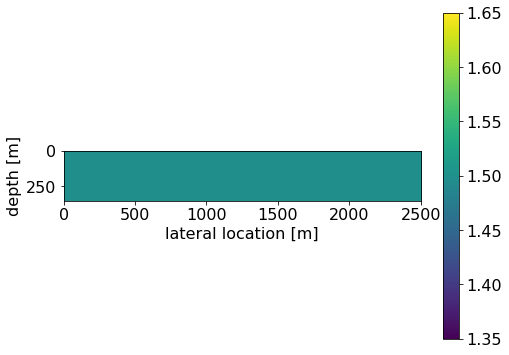

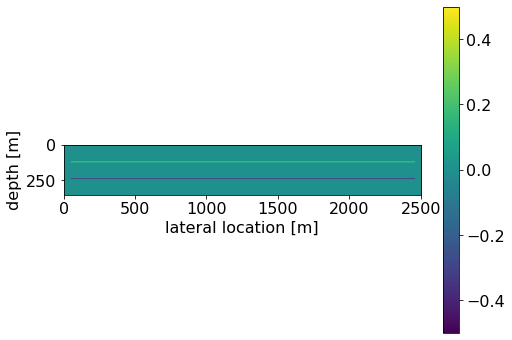

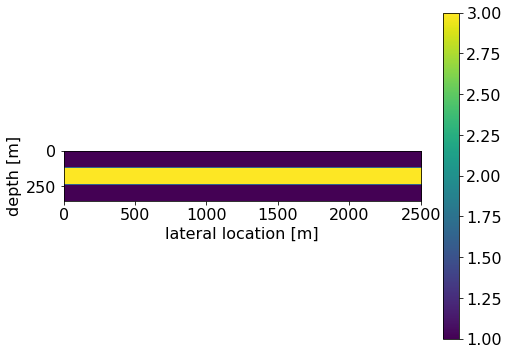

interactive(children=(IntSlider(value=10, description='it', max=614), Output()), _dom_classes=('widget-interac…

In [9]:
extent=[0,nx*dx,nz*dz,0]
plt.imshow(model.vp.data[:].T,extent=extent)
plt.xlabel('lateral location [m]')
plt.ylabel('depth [m]')
plt.colorbar()
plt.show()
plt.imshow(rmodel.data[:].T,extent=extent)
plt.xlabel('lateral location [m]')
plt.ylabel('depth [m]')
plt.colorbar()
plt.show()
plt.imshow(model_true.b.data[:].T,extent=extent)
plt.xlabel('lateral location [m]')
plt.ylabel('depth [m]')
plt.colorbar()
plt.show()

@interact(it=widgets.IntSlider(min=0, max=P0.shape[0], step=1, value=10))
def snap(it):
  extent=[0,nx*dx,nz*dz,0]
  plt.imshow(P0.data[it,...].T,vmin=-0.1,vmax=0.1,cmap='gray',extent=extent)
  plt.xlabel('lateral location [m]')
  plt.ylabel('depth [m]')
  plt.title('Born modelling (two-way wave equation)')
  plt.show()
  plt.imshow(P1.data[it,...].T,vmin=-0.1,vmax=0.1,cmap='gray',extent=extent)
  plt.xlabel('lateral location [m]')
  plt.ylabel('depth [m]')
  plt.title('FD modelling (using reflectivity model)')
  plt.show()
  plt.imshow(P2.data[it,...].T,vmin=-0.1,vmax=0.1,cmap='gray',extent=extent)
  plt.xlabel('lateral location [m]')
  plt.ylabel('depth [m]')
  plt.title('FD modelling (using density model)')
  plt.show()